In [1]:
import numpy as np

def omp_regression(X, y, T):
    N, D = X.shape
    A = set()  # Active set
    B = set(range(D))  # Inactive set
    solutions = np.zeros((D, T))  # Matrix to store the solutions
    
    r = y.copy()  # Initialize the residual
    
    for t in range(T):
        correlations = np.abs(X[:, list(B)].T @ r)  # Compute correlations
        
        j_t = list(B)[np.argmax(correlations)]  # Find the column with maximum correlation
        
        A.add(j_t)  # Add column to the active set
        B.remove(j_t)  # Remove column from the inactive set
        
        X_t = X[:, list(A)]  # Active matrix
        
        # Solve the least squares problem
        beta_t = np.linalg.lstsq(X_t, y, rcond=None)[0]
        
        solutions[list(A), t] = beta_t  # Store the solution
        
        r = y - X_t @ beta_t  # Update the residual
    
    return solutions


Pixels ordered by importance:
[29 30 26 21 25 28 42 36  5 18 23 27 22 19 44 46  6 16  8 17 45 37 41 38
 12 53  1 58  4  2 33 14 20 54 61 55 63 13 10 57 15 60 34 51 52  7  3 59
 43 35 11 50 49  9 62  0 24 32 31 39 40 48 47 56]


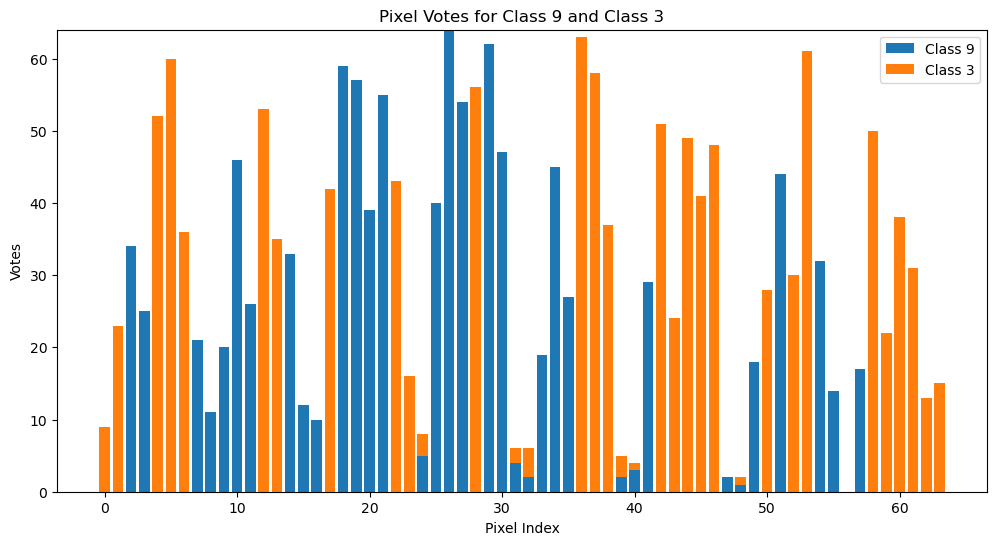

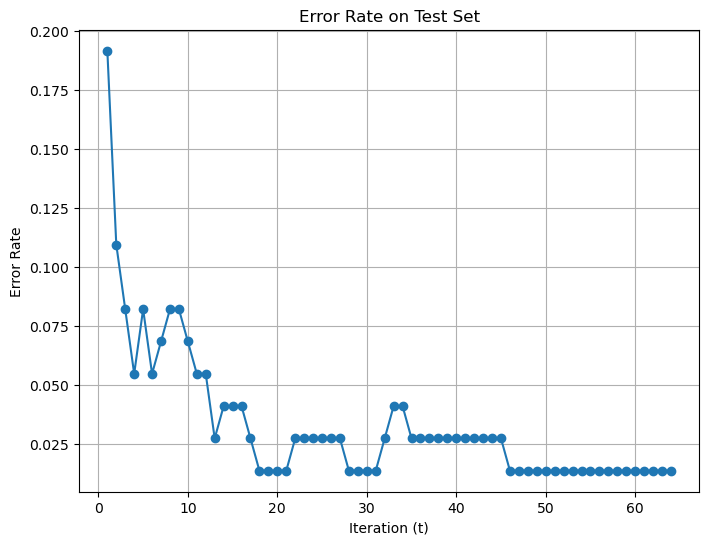

In [13]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# Load the digits dataset and split into training and test sets
digits = load_digits()
target = digits.target
data = digits.data
is_3_or_9 = np.logical_or(target == 3, target == 9)
data = data[is_3_or_9]
target = target[is_3_or_9]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

X_train_normalized = X_train / 16.0  # Normalize the training data
X_test_normalized = X_test / 16.0  # Normalize the test data
y_train_binary = np.where(y_train == 3, 1, -1)  # Convert labels to binary: 3 -> 1, 9 -> -1

# Execute the OMP algorithm and obtain the sequence of sparse LDA solutions
T = 64  # Number of iterations
solutions = omp_regression(X_train_normalized, y_train_binary, T)

# Compute the error rate on the test set for each solution
error_rates = []
for t in range(T):
    active_pixels = np.nonzero(solutions[:, t])[0]
    X_train_selected = X_train_normalized[:, active_pixels]
    X_test_selected = X_test_normalized[:, active_pixels]
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_selected, y_train)
    error_rate = 1.0 - lda.score(X_test_selected, y_test)
    error_rates.append(error_rate)

# Print the list of pixels ordered by importance
sorted_pixels = np.argsort(np.sum(np.abs(solutions), axis=1))[::-1]
print("Pixels ordered by importance:")
print(sorted_pixels)

# Plot the votes of each pixel for class '9' and class '3'
votes_9 = np.sum(np.where(solutions < 0, 1, 0), axis=1)
votes_3 = np.sum(np.where(solutions > 0, 1, 0), axis=1)

plt.figure(figsize=(12, 6))
plt.bar(range(len(votes_9)), votes_9, label='Class 9')
plt.bar(range(len(votes_3)), votes_3, label='Class 3', bottom=votes_9)
plt.xlabel('Pixel Index')
plt.ylabel('Votes')
plt.title('Pixel Votes for Class 9 and Class 3')
plt.legend()
plt.show()

# Plot the error rates
plt.figure(figsize=(8, 6))
plt.plot(range(1, T + 1), error_rates, marker='o')
plt.xlabel('Iteration (t)')
plt.ylabel('Error Rate')
plt.title('Error Rate on Test Set')
plt.grid(True)
plt.show()


### How many pixels should be used for acceptable error rates?
I would say, that 4 pixels seem to be enough. However, if you want to have the best possible error rates you would have to use 18 pixels.

### What is a good criterion for this distinction? (if a pixel votes for 3 or 9)
In the Solution Matrix positive values indicate that the pixel contributes to class '3', while negative values indicate that the pixel contributes to class '9'. The absolute value of the entry represents the strength or magnitude of the contribution.

### Compare these results with your hand-crafted feature selection in exercise 1 did you select the same pixels?
The pixels selected where not exactly in the same order of importance, but similar. The top 3 pixels in my solution from exercise 1 are the 1., 3. and 10th best pixel from the omp regression.